Aprendizado de máquina utilizando a biblioteca **TensorFlow**
Tutorial utilizado
https://www.tensorflow.org/tutorials/images/transfer_learning


In [57]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [58]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import time

# Pré-processamento de dados

## Download de dados

Neste tutorial, você usará um conjunto de dados contendo vários milhares de imagens de cães e gatos. Faça download e extraia um arquivo zip contendo as imagens e crie um **tf.data.Dataset** para treinamento e validação usando o utilitário **tf.keras.utils.image_dataset_from_directory**.

In [59]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)
PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

BATCH_SIZE = 32
IMG_SIZE = (160, 160)

train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

Found 2000 files belonging to 2 classes.


In [60]:
validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

Found 1000 files belonging to 2 classes.


Mostre as primeiras nove imagens e rótulos do conjunto de treinamento:

Se quiser mostra mais amostras altere estas linhas:
1. for i in range(9): substitua o número 9 que desejar
2. ax = plt.subplot(3, 3, i + 1), altere conforme desejar exibir.

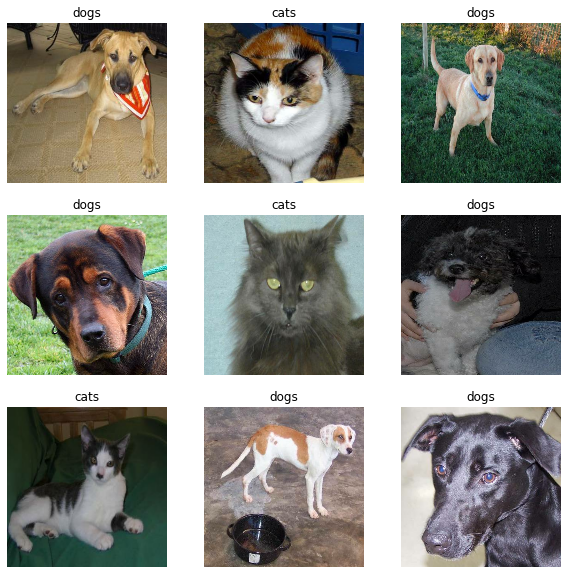

In [61]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

Como o conjunto de dados original não contém um conjunto de teste, você criará um. Para fazer isso, determine quantos lotes de dados estão disponíveis no conjunto de validação usando **tf.data.experimental.cardinality** e mova 20% deles para um conjunto de teste.

In [62]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

In [63]:
print('Número de lotes de validação: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Número de lotes de teste....: %d' % tf.data.experimental.cardinality(test_dataset))

Número de lotes de validação: 26
Número de lotes de teste....: 6


Usando a pré-busca em buffer para carregar imagens do disco sem que a E/S se torne um bloqueio. 

In [64]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

Quando você não tem um grande conjunto de dados de imagem, é uma boa prática introduzir artificialmente a diversidade de amostra aplicando transformações aleatórias, porém realistas, às imagens de treinamento, como rotação e inversão horizontal. Isso ajuda a expor o modelo a diferentes aspectos dos dados de treinamento e reduzir o **overfitting**.

(*Um cenário de **overfitting** ocorre quando, nos dados de treino, o modelo tem um desempenho excelente, porém quando utilizamos os dados de teste o resultado é ruim.*)

In [65]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

Aplicando repetidamente essas camadas na mesma imagem e ver o resultado.

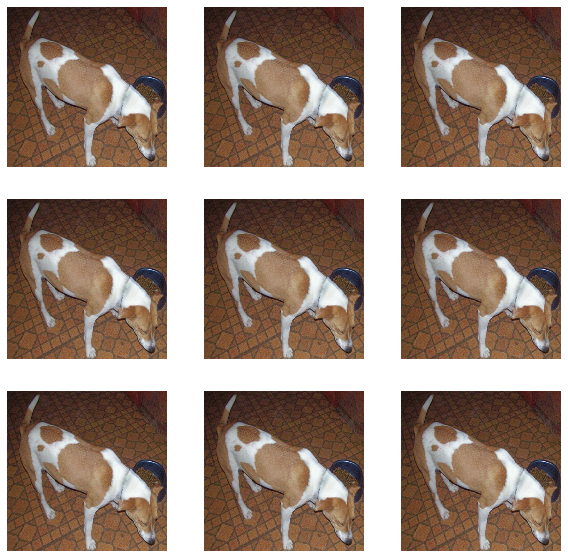

In [66]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

Usamos o **tf.keras.applications.MobileNetV2** como modelo base. Este modelo espera valores de pixel em [-1, 1] , mas neste ponto, os valores de pixel em suas imagens estão em [0, 255] . Para redimensioná-los, use o método de pré-processamento incluído no modelo.

In [67]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [68]:
rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)

Criamos o modelo base a partir do modelo MobileNet V2 desenvolvido no Google. Isso é pré-treinado no conjunto de dados ImageNet, um grande conjunto de dados que consiste em 1,4 milhão de imagens e 1.000 classes. ImageNet é um conjunto de dados de treinamento de pesquisa com uma ampla variedade de categorias, como **jackfruit** e **syringe**. Essa base de conhecimento nos ajudará a classificar cães e gatos de nosso conjunto de dados específico.

Instanciamos um modelo MobileNet V2 pré-carregado com pesos treinados no ImageNet. Ao especificar o argumento include_top=False, você carregamos uma rede que não inclui as camadas de classificação na parte superior, o que é ideal para extração de recursos.

In [69]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

Este extrator de recursos converte cada imagem de 160x160x3 em um bloco de recursos de 5x5x1280.

In [70]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


É importante congelar a base convolucional antes de compilar e treinar o modelo. O congelamento (definindo layer.trainable = False) evita que os pesos em uma determinada camada sejam atualizados durante o treinamento. O MobileNet V2 tem muitas camadas, portanto, definir o sinalizador trainable de todo o modelo como False irá congelar todas elas.

In [71]:
base_model.trainable = False

In [72]:
# Let's take a look at the base model architecture
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 80, 80, 32)   864         ['input_3[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 80, 80, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 80, 80, 32)   0           ['bn_Conv1[0][

Para gerar previsões a partir do bloco de feições, calcule a média das localizações espaciais 5x5 , usando uma camada **tf.keras.layers.GlobalAveragePooling2D** para converter as feições em um único vetor de 1280 elementos por imagem.

In [73]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


Aplique uma camada **tf.keras.layers.Dense** para converter esses recursos em uma única previsão por imagem. Você não precisa de uma função de ativação aqui porque essa previsão será tratada como um logit ou um valor bruto de previsão. Números positivos predizem a classe 1, números negativos predizem a classe 0.

In [74]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


In [75]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

Compilando o modelo antes de treiná-lo. Como existem duas classes, use a perda **tf.keras.losses.BinaryCrossentropy** com **from_logits=True**, pois o modelo fornece uma saída linear.

In [76]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [77]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv_1 (TFOpLamb  (None, 160, 160, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_1 (TFOpLam  (None, 160, 160, 3)      0         
 bda)                                                            
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                           

In [78]:
len(model.trainable_variables)

2

Após treinar por 10 épocas, você deverá ver ~ 94% de precisão no conjunto de validação.

In [79]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(validation_dataset)

26/26 [==============================] - 4s 60ms/step - loss: 0.8997 - accuracy: 0.3886


In [80]:
print("perda inicial...: {:.2f}".format(loss0))
print("precisão inicial: {:.2f}".format(accuracy0))

perda inicial...: 0.90
precisão inicial: 0.39


In [81]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/10
63/63 [==============================] - 9s 82ms/step - loss: 0.8012 - accuracy: 0.4940 - val_loss: 0.5860 - val_accuracy: 0.6510
Epoch 2/10
63/63 [==============================] - 5s 80ms/step - loss: 0.5687 - accuracy: 0.6790 - val_loss: 0.4108 - val_accuracy: 0.8156
Epoch 3/10
63/63 [==============================] - 5s 78ms/step - loss: 0.4483 - accuracy: 0.7620 - val_loss: 0.3166 - val_accuracy: 0.8775
Epoch 4/10
63/63 [==============================] - 5s 80ms/step - loss: 0.3671 - accuracy: 0.8390 - val_loss: 0.2511 - val_accuracy: 0.9171
Epoch 5/10
63/63 [==============================] - 5s 80ms/step - loss: 0.3232 - accuracy: 0.8565 - val_loss: 0.2091 - val_accuracy: 0.9344
Epoch 6/10
63/63 [==============================] - 5s 81ms/step - loss: 0.2866 - accuracy: 0.8765 - val_loss: 0.1783 - val_accuracy: 0.9468
Epoch 7/10
63/63 [==============================] - 5s 82ms/step - loss: 0.2570 - accuracy: 0.9015 - val_loss: 0.1660 - val_accuracy: 0.9406
Epoch 8/10
63

Curvas de aprendizado

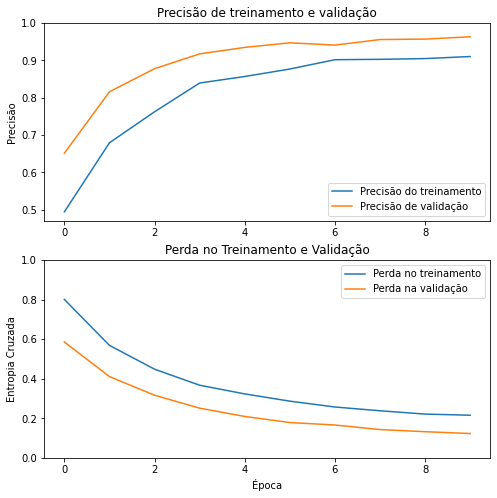

In [82]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Precisão do treinamento')
plt.plot(val_acc, label='Precisão de validação')
plt.legend(loc='lower right')
plt.ylabel('Precisão')
plt.ylim([min(plt.ylim()),1])
plt.title('Precisão de treinamento e validação')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Perda no treinamento')
plt.plot(val_loss, label='Perda na validação')
plt.legend(loc='upper right')
plt.ylabel('Entropia Cruzada')
plt.ylim([0,1.0])
plt.title('Perda no Treinamento e Validação')
plt.xlabel('Época')
plt.show()

Uma maneira de aumentar ainda mais o desempenho é treinar (ou "ajustar") os pesos das camadas superiores do modelo pré-treinado juntamente com o treinamento do classificador que você adicionou. O processo de treinamento forçará os pesos a serem ajustados de mapas de recursos genéricos para recursos associados especificamente ao conjunto de dados.



In [83]:
base_model.trainable = True

In [84]:
# Let's take a look to see how many layers are in the base model
print("Número de camadas no modelo base: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Número de camadas no modelo base:  154


In [85]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])

In [86]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv_1 (TFOpLamb  (None, 160, 160, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_1 (TFOpLam  (None, 160, 160, 3)      0         
 bda)                                                            
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                           

In [87]:
len(model.trainable_variables)

56

In [88]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 10/20
63/63 [==============================] - 11s 103ms/step - loss: 0.1516 - accuracy: 0.9355 - val_loss: 0.0500 - val_accuracy: 0.9814
Epoch 11/20
63/63 [==============================] - 6s 89ms/step - loss: 0.1331 - accuracy: 0.9475 - val_loss: 0.0427 - val_accuracy: 0.9864
Epoch 12/20
63/63 [==============================] - 6s 90ms/step - loss: 0.1209 - accuracy: 0.9530 - val_loss: 0.0474 - val_accuracy: 0.9851
Epoch 13/20
63/63 [==============================] - 6s 89ms/step - loss: 0.0951 - accuracy: 0.9615 - val_loss: 0.0386 - val_accuracy: 0.9889
Epoch 14/20
63/63 [==============================] - 6s 89ms/step - loss: 0.0908 - accuracy: 0.9640 - val_loss: 0.0577 - val_accuracy: 0.9740
Epoch 15/20
63/63 [==============================] - 7s 100ms/step - loss: 0.0894 - accuracy: 0.9625 - val_loss: 0.0691 - val_accuracy: 0.9703
Epoch 16/20
63/63 [==============================] - 6s 92ms/step - loss: 0.0724 - accuracy: 0.9730 - val_loss: 0.0317 - val_accuracy: 0.9889
Epo

In [89]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

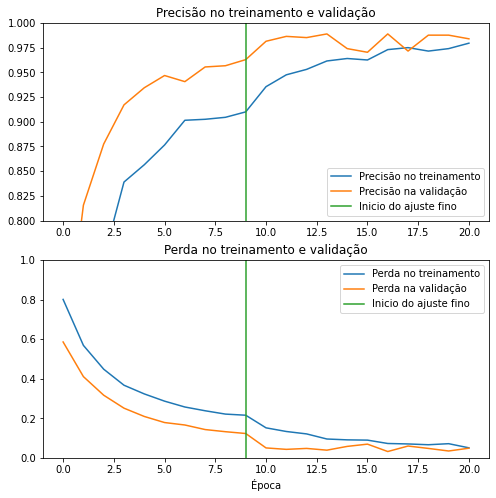

In [90]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Precisão no treinamento')
plt.plot(val_acc, label='Precisão na validação')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Inicio do ajuste fino')
plt.legend(loc='lower right')
plt.title('Precisão no treinamento e validação')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Perda no treinamento')
plt.plot(val_loss, label='Perda na validação')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Inicio do ajuste fino')
plt.legend(loc='upper right')
plt.title('Perda no treinamento e validação')
plt.xlabel('Época')
plt.show()

In [91]:
loss, accuracy = model.evaluate(test_dataset)
print('Precisão do teste: ', accuracy)

6/6 [==============================] - 1s 43ms/step - loss: 0.0428 - accuracy: 0.9844
Precisão do teste:  0.984375


Previsões:
 [0 0 0 1 1 0 0 1 0 0 0 1 1 0 1 0 1 1 0 0 0 1 1 0 0 1 1 0 1 1 1 1]
Etiquetas:
 [0 0 0 0 1 0 0 1 0 0 0 1 1 0 1 0 0 1 0 0 0 1 1 0 0 1 1 0 0 0 1 1]


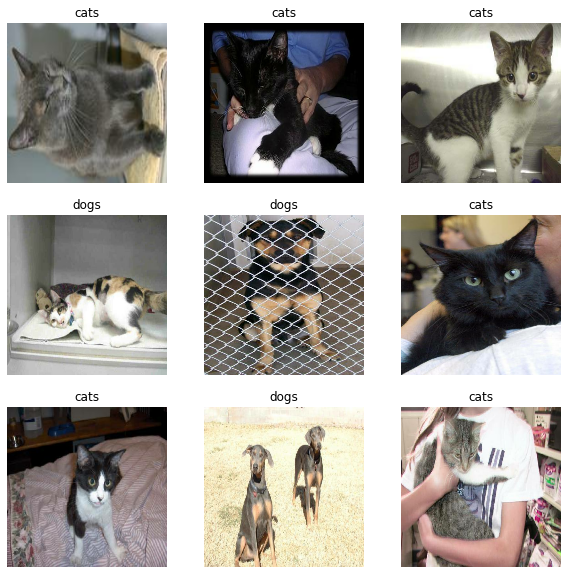

In [92]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Previsões:\n', predictions.numpy())
print('Etiquetas:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")

# Exportando o modelo treinado

In [93]:
t = time.time()

export_path = "/content/drive/MyDrive/DIO/transfer_learning_projeto_final/{}".format(int(t))
model.save(export_path, save_format='tf')

export_path

'/content/drive/MyDrive/DIO/transfer_learning_projeto_final/1668368332'

In [94]:
reloaded = tf.keras.models.load_model(export_path)

In [95]:
result_batch = model.predict(image_batch)

1/1 [==============================] - 1s 717ms/step


In [96]:
reloaded_result_batch = reloaded.predict(image_batch)

1/1 [==============================] - 1s 725ms/step


In [97]:

abs(reloaded_result_batch - result_batch).max()

0.0

Este modelo salvo pode ser carregado para inferência posteriormente ou convertido para [**TFLite**](https://www.tensorflow.org/lite/convert/) ou [**TFjs**](https://github.com/tensorflow/tfjs-converter).
